In [1]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk

import pandas as pd
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/swapnil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('prepared_abuse_data.csv')
df = df[df['annotation']!=2]

In [3]:
df

,tweet id,annotation,tweet text,tweet user id,tweet user,retweet_user
4,575595652006068224,1.0,I'm nervous for Annie. Kat is gonna tear her a...,37413076,GlobeAlone,[]
8,563306785302642688,1.0,@Dreysander1 Should be. I already have the adv...,2756873076,MT8_9,[]
10,502319195909263362,1.0,Just one of the many perks. @FzFarulsweg Im no...,930620467,YesYoureSexist,[]
24,575957533572997121,1.0,Can Kat get any nastier? #mkr,573614242,dumbadm1n,[]
35,568864544300396544,1.0,RT @asredasmyhair: And what rights would those...,2756873076,MT8_9,[]
...,...,...,...,...,...,...
7833,405464683630436353,1.0,RT @bigjhill23: This chick amy schumer is 2 fu...,13857342,randileeharper,[]
7834,425483093688852480,1.0,RT @JRamirez_3 I'm not sexist... But why the h...,13857342,randileeharper,[]
7844,572352765432709120,1.0,Oh look get the vacuum there's crumbs on that ...,2756873076,MT8_9,[]
7845,432289012317814784,1.0,RT @rfc884: I'm not sexist but I bet if I had ...,2756873076,MT8_9,[]


In [4]:
import preprocessor as p
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [5]:
text = df['tweet text'].apply(lambda x: p.clean(x))

In [6]:
stop = set(stopwords.words('english'))
exclude = set(punctuation)
lemma = WordNetLemmatizer()

def clean_data(data):
    stop_free = ' '.join([i for i in data.lower().split() if i not in stop])
    punct_free = ' '.join([ch for ch in stop_free.split() if ch not in exclude])
    normalized = " ".join(lemma.lemmatize(word) for word in punct_free.split())
    return normalized

In [7]:
data = [clean_data(line) for line in text]
# data

In [8]:
cv = CountVectorizer(stop_words='english',min_df=2,max_df=0.95)
dtm = cv.fit_transform(data)

In [9]:
LDA = LatentDirichletAllocation(n_components=2,random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=2, random_state=42)

In [10]:
single_topic = LDA.components_[0].argsort()
for i in single_topic[-10:]:
    print(cv.get_feature_names()[i])

know
football
like
im
women
men
girl
female
woman
sexist


In [11]:
for index,topic in enumerate(LDA.components_):
    print(f'Top 15 words of Topic {index}')
    print([cv.get_feature_names()[idx] for idx in topic.argsort()[-10:]])
    print('\n')

Top 15 words of Topic 0
['know', 'football', 'like', 'im', 'women', 'men', 'girl', 'female', 'woman', 'sexist']


Top 15 words of Topic 1
['face', 'bitch', 'need', 'people', 'feminism', 'amp', 'think', 'girl', 'like', 'kat']




In [12]:
word_dict = {}
for index,topic in enumerate(LDA.components_):
    word = [cv.get_feature_names()[idx] for idx in topic.argsort()[-10:]]
    word_dict[f'topic {index}'] = word
pd.DataFrame(word_dict)

,topic 0,topic 1
0,know,face
1,football,bitch
2,like,need
3,im,people
4,women,feminism
5,men,amp
6,girl,think
7,female,girl
8,woman,like
9,sexist,kat


In [13]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [14]:
word_dict = {}

for index,topic in enumerate(LDA.components_):
    name = []
    word = [cv.get_feature_names()[idx] for idx in topic.argsort()[-30:]]
    for ent in nlp(u' '.join(word)).noun_chunks:
        #print(str(spacy.explain(ent.label_)))
        #print('\n')
        print(ent.text)
        #name.append(str(spacy.explain(ent.label_)))
        name.append(ent.text)
    print('\n')
    word_dict[f'{name[0]}'] = word
named_topic = pd.DataFrame(word_dict)

comedian
feminist
lol
man
sport
football
i
women men


katie
yes nikki really hot andre cook
blonde way
bitch
people
feminism amp
girl
kat




In [15]:
name

['katie',
 'yes nikki really hot andre cook',
 'blonde way',
 'bitch',
 'people',
 'feminism amp',
 'girl',
 'kat']

In [16]:
named_topic.head()

,comedian,katie
0,comedian,katie
1,stand,want
2,care,equality
3,drive,hope
4,time,yes


In [17]:
topic_one =nlp(u' '.join([(cv.get_feature_names()[idx]) for idx in single_topic[-30:]]))

In [18]:
topic_one

comedian stand care drive time look thing guy say feminist make lol funny really hate right want man think sport know football like im women men girl female woman sexist

In [19]:
doc = nlp(u'swap')
for ent in nlp(u' '.join(cv.get_feature_names()[-10:])).ents:
    print(str(spacy.explain(ent.label_)) )

Absolute or relative dates or periods
People, including fictional
Numerals that do not fall under another type


In [20]:
from spacy import displacy

In [21]:
displacy.render(topic_one,style='ent',jupyter=True)

/home/swapnil/.local/lib/python3.8/site-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
%matplotlib inline

In [23]:
l ="he bought 2 pencils, 3 erasers, and 1 pencil-sharpener."

len('alice')

5

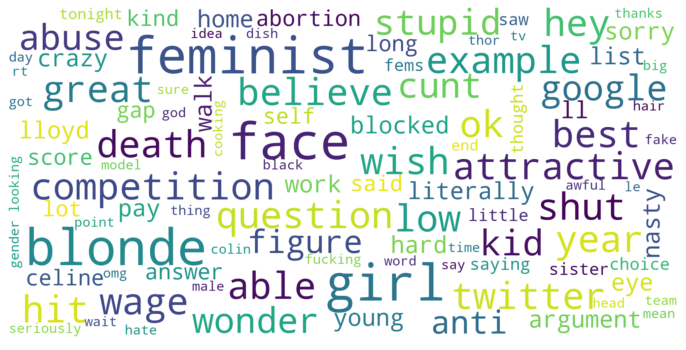

In [24]:
plt.figure(figsize=(10,6)) 
topic_words = ' '.join([cv.get_feature_names()[i] for i in topic.argsort()[-150:]])

word_cloud = WordCloud(background_color='white',
                           max_words=100,
                           max_font_size=30,
                           scale=5,
                           random_state=1).generate(topic_words)

plt.imshow(word_cloud,interpolation="bilinear")
plt.tight_layout()
plt.axis("off")
plt.show()

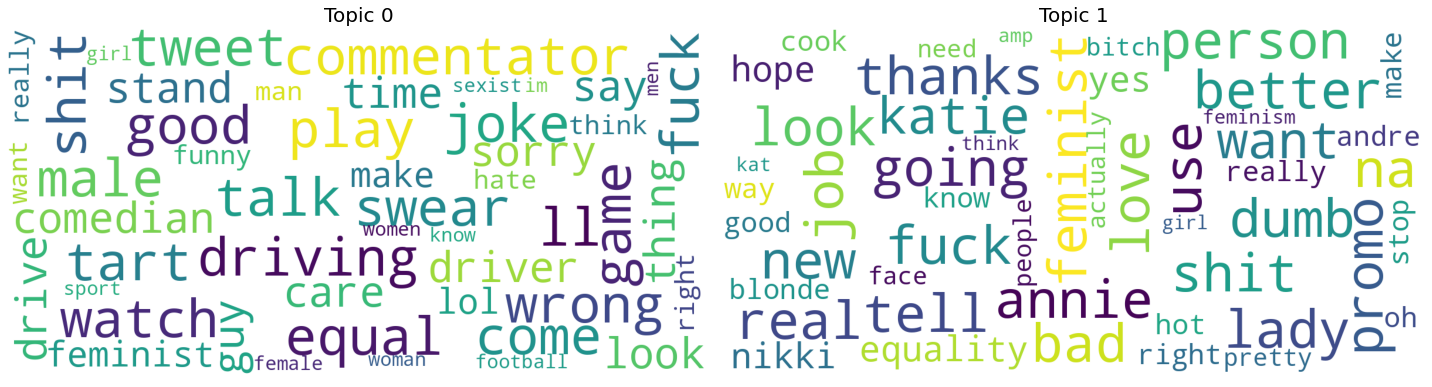

In [74]:
ncol=2
n_clust =2
nrows=ceil(n_clust/ncol)
fig, axeslist = plt.subplots(ncols=ncol,nrows=nrows, figsize=(20,20))
cnt=0
for index,topic in enumerate(LDA.components_):
    name = []
    topic_words = ' '.join([cv.get_feature_names()[i] for i in topic.argsort()[-50:]])
    word_cloud = WordCloud(background_color='white',
                           max_words=1000,
                           max_font_size=30,
                           scale=3,
                           random_state=1).generate(topic_words)
    for ent in nlp(u' '.join([cv.get_feature_names()[i] for i in topic.argsort()[-30:]])).noun_chunks:
        name.append(ent.text)
    axeslist.ravel()[index].imshow(word_cloud)
    axeslist.ravel()[index].set_title(f'Topic {cnt}',fontsize=20)
    axeslist.ravel()[index].set_axis_off()
    cnt+=1
plt.tight_layout()
plt.show()

In [58]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

df['neg'] = df['tweet text'].apply(lambda x: sid.polarity_scores(x)['neg'])
df['pos'] = df['tweet text'].apply(lambda x: sid.polarity_scores(x)['pos'])
df['neu'] = df['tweet text'].apply(lambda x: sid.polarity_scores(x)['neu'])



In [62]:
tot = sum([sum(df['neg']), sum(df['pos'])])

In [63]:
df

,tweet id,annotation,tweet text,tweet user id,tweet user,retweet_user,neg,pos,neu
4,575595652006068224,1.0,I'm nervous for Annie. Kat is gonna tear her a...,37413076,GlobeAlone,[],0.110,0.000,0.890
8,563306785302642688,1.0,@Dreysander1 Should be. I already have the adv...,2756873076,MT8_9,[],0.000,0.000,1.000
10,502319195909263362,1.0,Just one of the many perks. @FzFarulsweg Im no...,930620467,YesYoureSexist,[],0.104,0.115,0.781
24,575957533572997121,1.0,Can Kat get any nastier? #mkr,573614242,dumbadm1n,[],0.398,0.000,0.602
35,568864544300396544,1.0,RT @asredasmyhair: And what rights would those...,2756873076,MT8_9,[],0.000,0.000,1.000
...,...,...,...,...,...,...,...,...,...
7833,405464683630436353,1.0,RT @bigjhill23: This chick amy schumer is 2 fu...,13857342,randileeharper,[],0.099,0.073,0.827
7834,425483093688852480,1.0,RT @JRamirez_3 I'm not sexist... But why the h...,13857342,randileeharper,[],0.000,0.000,1.000
7844,572352765432709120,1.0,Oh look get the vacuum there's crumbs on that ...,2756873076,MT8_9,[],0.000,0.000,1.000
7845,432289012317814784,1.0,RT @rfc884: I'm not sexist but I bet if I had ...,2756873076,MT8_9,[],0.065,0.000,0.935


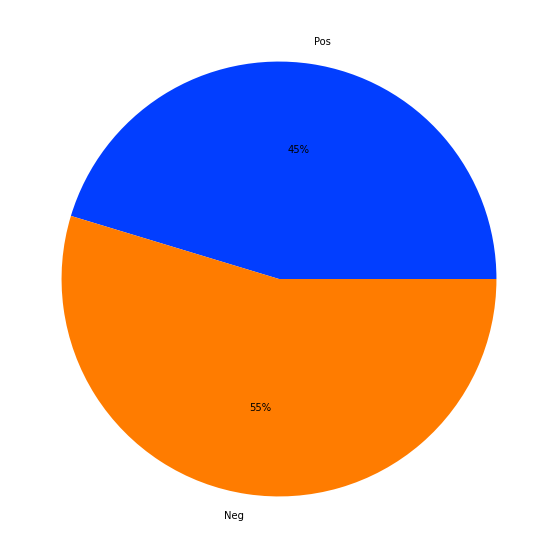

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
plt.figure(figsize=(12,10)) 
data = [sum(df['pos'])/tot * 100, sum(df['neg'])/tot * 100]
labels = ['Pos', 'Neg']

#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [28]:
#Import the modules
import text2emotion as te

#Call to the function
te.get_emotion(df['tweet text'][4])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/swapnil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/swapnil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/swapnil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


{'Happy': 0.0, 'Angry': 0.33, 'Surprise': 0.0, 'Sad': 0.33, 'Fear': 0.33}

In [29]:
temp_emo = df['tweet text'].apply(lambda x:te.get_emotion(x))

In [41]:
emotion = pd.DataFrame()
emotion['Happy'] = list(temp_emo.apply(lambda x:x['Happy']))
emotion['Angry'] = list(temp_emo.apply(lambda x:x['Angry']))
emotion['Surprise'] = list(temp_emo.apply(lambda x:x['Surprise']))
emotion['Sad'] = list(temp_emo.apply(lambda x:x['Sad']))
emotion['Fear'] = list(temp_emo.apply(lambda x:x['Fear']))

tot = sum([sum(emotion['Happy']), sum(emotion['Angry']), sum(emotion['Surprise']), sum(emotion['Sad']), sum(emotion['Fear'])])

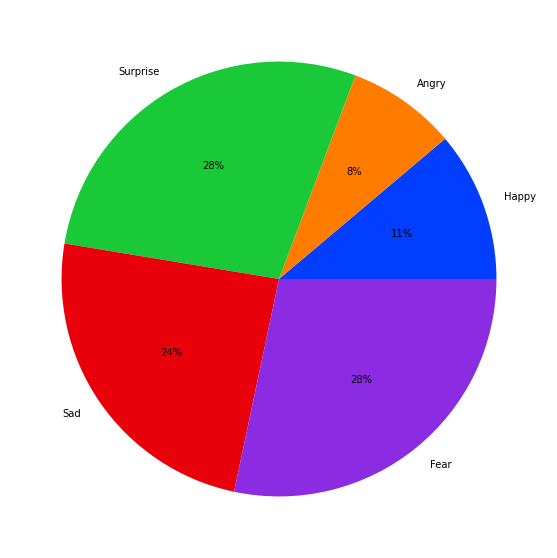

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
plt.figure(figsize=(12,10)) 
data = [sum(emotion['Happy'])/tot * 100, sum(emotion['Angry'])/tot * 100,
        sum(emotion['Surprise'])/tot * 100, sum(emotion['Sad'])/tot * 100,
        sum(emotion['Fear'])/tot * 100]
labels = ['Happy', 'Angry', 'Surprise', 'Sad', 'Fear']

#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()